In [202]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import plotly.express as px
import plotly.graph_objects as go

from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

from tslearn.preprocessing import TimeSeriesResampler
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import AgglomerativeClustering


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from dtaidistance import msm
from sktime.distances import msm_distance

In [2]:
df = pd.read_csv('D:/Study/Education/Projects/ML2/Final/notebook/cleaned_data.csv', index_col = 0)
df = df.rename(columns = {'card1': 'CardID'})

In [3]:
df

isFraud  TransactionDT  TransactionAmt ProductCD  CardID  card2  \
0             0          86400           68.50         W   13926  361.0   
1             0          86401           29.00         W    2755  404.0   
2             0          86469           59.00         W    4663  490.0   
3             0          86499           50.00         W   18132  567.0   
4             0          86506           50.00         H    4497  514.0   
...         ...            ...             ...       ...     ...    ...   
587436        0       15811047           49.00         W    6550  361.0   
587437        0       15811049           39.50         W   10444  225.0   
587438        0       15811079           30.95         W   12037  595.0   
587439        0       15811088          117.00         W    7826  481.0   
587440        0       15811131          279.95         W   15066  170.0   

        card3       card4  card5   card6  ...         4         5         6  \
0       150.0    discover  142.0  credit  ... -1.653196 -0.139864 -0.731344   
1       150.0  mastercard  102.0  credit  ... -1.486360 -0.065914  1.490355   
2       150.0        visa  166.0   debit  ... -1.289957 -1.210241  0.156661   
3       150.0  mastercard  117.0   debit  ...  0.554579  1.270003  0.994639   
4       150.0  mastercard  102.0  credit  ... -1.512392 -1.440297  0.167592   
...       ...         ...    ...     ...  ...       ...       ...       ...   
587436  150.0        visa  226.0   debit  ... -0.412590  2.729602 -4.583025   
587437  150.0  mastercard  224.0   debit  ... -1.289957 -1.210241  0.156661   
587438  150.0  mastercard  224.0   debit  ...  1.133218 -1.634551  0.166640   
587439  150.0  mastercard  224.0   debit  ...  6.092759 -3.102880  4.243500   
587440  150.0  mastercard  102.0  credit  ...  1.529059 -3.583309 -3.281668   

               7         8         9        10        11        12        13  
0       0.299316 -0.028130 -0.277146  0.920667  0.358542 -0.296964  0.380415  
1      -1.655177 -0.215142  1.449773 -2.763051 -0.165358 -0.541320  0.456912  
2       0.202122 -0.308079  0.340094  0.530225  0.370691  0.141100  0.307816  
3      -1.923996 -1.534586  0.643949  1.771153 -0.322066 -2.634591 -1.304962  
4       0.707883 -0.289322  0.231737  0.871760  0.689639  0.345136 -0.121816  
...          ...       ...       ...       ...       ...       ...       ...  
587436  2.977019 -0.171590 -2.824073  3.033108 -0.247088  0.376417  0.589979  
587437  0.202122 -0.308079  0.340094  0.530225  0.370691  0.141100  0.307816  
587438  1.342422 -0.381594 -0.054540  1.298806  0.488629  0.627749 -0.116707  
587439  0.582027 -2.239760  0.561281 -1.235204 -1.303856  2.054611  0.488238  
587440  3.218498  2.325731  1.813219  3.648037 -1.302375  2.194140  0.204883  

[587441 rows x 51 columns]

<Axes: xlabel='TransactionDT', ylabel='Count'>

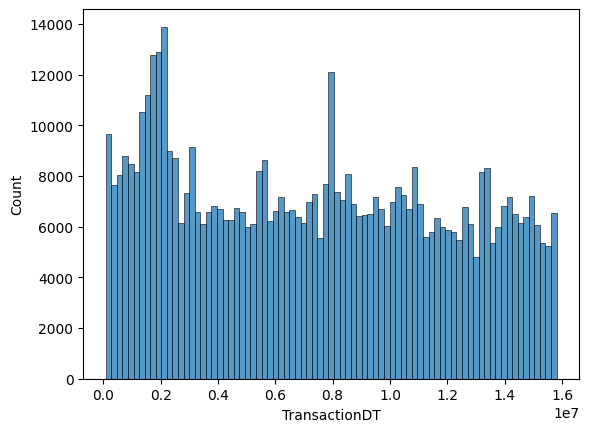

In [3]:
sns.histplot(df['TransactionDT'])

In [3]:
##Convert Datetime to Hour
df['TransactionDT'] = df['TransactionDT']/3600

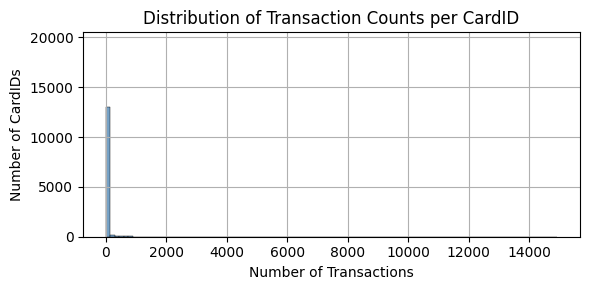

In [62]:
cardid_counts = df['CardID'].value_counts()

# Step 2: Plot histogram of those counts
plt.figure(figsize=(6, 3))
sns.histplot(cardid_counts, bins=100, kde=False, color='steelblue')

# Step 3: Adjust y-axis max to 1.5 * max count for clarity
y_max = plt.gca().get_ylim()[1]
plt.ylim(0, y_max * 1.5)

# Step 4: Labels and aesthetics
plt.title('Distribution of Transaction Counts per CardID')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of CardIDs')
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
df1 = df[['CardID', 'isFraud']].groupby('CardID')['isFraud'].max().reset_index()

In [79]:
df1['isFraud'].value_counts()

isFraud
0    11808
1     1735
Name: count, dtype: int64

In [113]:
count = df['CardID'].value_counts()

for i in range(20, 200, 15):
    count_g = count[count > i].index
    df_g = df[df['CardID'].isin(count_g)]
    df_g = df_g[['CardID', 'isFraud']].groupby('CardID')['isFraud'].max().reset_index()
    
    label_counts = df_g['isFraud'].value_counts()
    
    fraud = label_counts.get(1, 0)
    non_fraud = label_counts.get(0, 0)
    
    ratio = fraud / non_fraud if non_fraud != 0 else float('inf')
    
    print('------------------')
    print(f'Threshold > {i}:')
    print(f'Fraud count: {fraud}, Non-fraud count: {non_fraud}')
    print(f'Fraud/Non-fraud ratio: {ratio:.4f}')

------------------
Threshold > 20:
Fraud count: 985, Non-fraud count: 1548
Fraud/Non-fraud ratio: 0.6363
------------------
Threshold > 35:
Fraud count: 839, Non-fraud count: 812
Fraud/Non-fraud ratio: 1.0333
------------------
Threshold > 50:
Fraud count: 726, Non-fraud count: 505
Fraud/Non-fraud ratio: 1.4376
------------------
Threshold > 65:
Fraud count: 656, Non-fraud count: 348
Fraud/Non-fraud ratio: 1.8851
------------------
Threshold > 80:
Fraud count: 598, Non-fraud count: 245
Fraud/Non-fraud ratio: 2.4408
------------------
Threshold > 95:
Fraud count: 550, Non-fraud count: 185
Fraud/Non-fraud ratio: 2.9730
------------------
Threshold > 110:
Fraud count: 510, Non-fraud count: 152
Fraud/Non-fraud ratio: 3.3553
------------------
Threshold > 125:
Fraud count: 474, Non-fraud count: 119
Fraud/Non-fraud ratio: 3.9832
------------------
Threshold > 140:
Fraud count: 443, Non-fraud count: 99
Fraud/Non-fraud ratio: 4.4747
------------------
Threshold > 155:
Fraud count: 421, Non-fra

## Sketching of Fraud Card Transaction logs

In [11]:
fig = px.line(fraud_card, x='TransactionDT', y='TransactionAmt', color='CardID')

# Add fraud markers per CardID
for card in fraud_card['CardID'].unique():
    fraud_subset = fraud_card[(fraud_card['CardID'] == card) & (fraud_card['isFraud'] == 1)]
    
    if not fraud_subset.empty:
        fig.add_trace(
            go.Scatter(
                x=fraud_subset['TransactionDT'],
                y=fraud_subset['TransactionAmt'],
                mode='markers',
                marker=dict(symbol='x', size=10, color='black'),
                name=f'Fraud: Card {card}',
                legendgroup=str(card),
                showlegend=True
            )
        )

fig.update_layout(title="Transaction Amounts with Fraud Markers per CardID")
fig.show()

#### Drop outlier 

In [4]:
df = df[df['TransactionAmt'] < 30000]

## Add 1 more label to the Data

In [18]:
fraud_count_per_card = df[df['isFraud'] == 1].groupby('CardID').size().reset_index(name='fraud_txn_count')

# Total transactions per card
total_txn_per_card = df.groupby('CardID').size().reset_index(name='total_txn_count')

# Merge fraud and total transactions
card_summary = pd.merge(total_txn_per_card, fraud_count_per_card, on='CardID', how='left')
card_summary['fraud_txn_count'] = card_summary['fraud_txn_count'].fillna(0).astype(int)
card_summary['fraud_rate'] = card_summary['fraud_txn_count'] / card_summary['total_txn_count']

# 🔍 Filter: only cards with > 20 transactions
card_summary = card_summary[(card_summary['total_txn_count'] > 20) & (card_summary['total_txn_count'] < 200)]

card_summary

CardID  total_txn_count  fraud_txn_count  fraud_rate
23       1028               37                0    0.000000
25       1030              123                1    0.008130
41       1047               22                4    0.181818
61       1070               23                0    0.000000
80       1092               42                0    0.000000
...       ...              ...              ...         ...
13496   18335               22                1    0.045455
13529   18376               25                0    0.000000
13530   18377               28                0    0.000000
13535   18385               40                0    0.000000
13538   18390               64                0    0.000000

[2103 rows x 4 columns]

<Axes: xlabel='fraud_rate', ylabel='Count'>

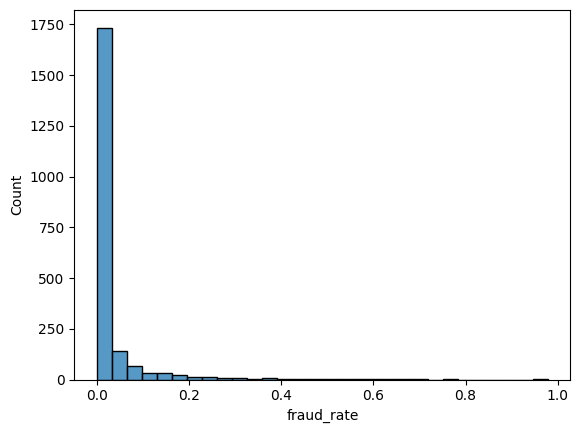

In [10]:
sns.histplot(card_summary['fraud_rate'], bins = 30)

In [19]:
card_summary['Fraud_level'] = card_summary['fraud_rate'].apply(lambda x: 1 if x < 0.05 else 2)

In [20]:
card_summary    

CardID  total_txn_count  fraud_txn_count  fraud_rate  Fraud_level
23       1028               37                0    0.000000            1
25       1030              123                1    0.008130            1
41       1047               22                4    0.181818            2
61       1070               23                0    0.000000            1
80       1092               42                0    0.000000            1
...       ...              ...              ...         ...          ...
13496   18335               22                1    0.045455            1
13529   18376               25                0    0.000000            1
13530   18377               28                0    0.000000            1
13535   18385               40                0    0.000000            1
13538   18390               64                0    0.000000            1

[2103 rows x 5 columns]

<Axes: xlabel='Fraud_level', ylabel='count'>

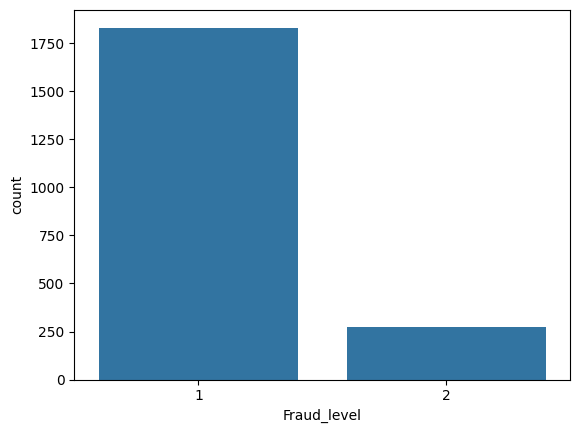

In [73]:
sns.countplot(data = card_summary, x = 'Fraud_level')

### Splitting to Clusters using SoftDTW to compare relative transaction type

### By TransactionAmount

In [ ]:
sequences = []
card_ids = []

for card_id, group in df.groupby('CardID'):
    seq = group.sort_values('TransactionDT')['TransactionAmt'].values
    if len(seq) < 35:
        continue  # skip card with less than 35
    card_ids.append(card_id)
    sequences.append(seq)

ts_dataset = to_time_series_dataset(sequences)
ts_dataset = TimeSeriesResampler(sz=50).fit_transform(ts_dataset) #Pad and truncate all to 50 transactions fixed


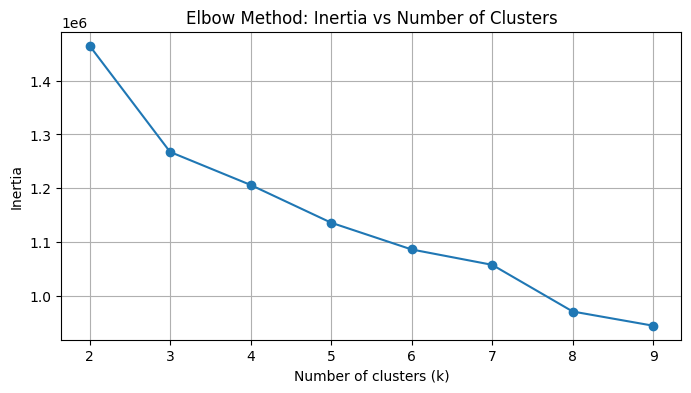

In [ ]:
inertias = []

K_range = range(2, 10)

# --- Run clustering for each k ---
for k in K_range:
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=0)
    model.fit(ts_dataset)
    inertias.append(model.inertia_)

# --- Plot the elbow curve ---
plt.figure(figsize=(8, 4))
plt.plot(list(K_range), inertias, marker='o')
plt.title("Elbow Method: Inertia vs Number of Clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [ ]:
# DTW-based clustering
dtw_kmeans = TimeSeriesKMeans(n_clusters=4, metric="softdtw", random_state=42)
cluster_labels = dtw_kmeans.fit_predict(ts_dataset)

dtw_clusters_df = pd.DataFrame({'CardID': card_ids, 'dtw_cluster': cluster_labels})

In [ ]:
centroids = dtw_kmeans.cluster_centers_
labels = cluster_labels
X = ts_dataset

# Ensure X is 2D: (n_samples, time_length)
if X.ndim == 3:
    X = X.squeeze(-1)

n_clusters = len(centroids)
n_rows, n_cols = 2, 2

colors = ['blue', 'green', 'red', 'orange']

# Find global y-limits to set scale for all graphs
all_values = np.concatenate([c.squeeze() for c in centroids])
y_min, y_max = all_values.min(), all_values.max()

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 6))
axes = axes.flatten()

for i, centroid in enumerate(centroids):
    ax = axes[i]
    cluster_ts = X[labels == i]  # Time series in this cluster
    n_series = cluster_ts.shape[0]
    mean_ts = np.mean(cluster_ts, axis=0)
    std_ts = np.std(cluster_ts, axis=0)
    ci_margin = 1.96 * std_ts / np.sqrt(n_series)  # 95% CI (5% alpha)

    color = colors[i % len(colors)]
    ax.plot(centroid.squeeze(), color=color, label='Centroid')
    ax.fill_between(range(len(mean_ts)),
                    mean_ts - ci_margin,
                    mean_ts + ci_margin,
                    color=color,
                    alpha=0.2,
                    label='95% CI')
    ax.set_title(f"Cluster {i}")
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)
    ax.legend()

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.tight_layout()
plt.show()

#### Define test dataset with Flagged CardID


In [134]:
cardid_counts = df['CardID'].value_counts()
cardids_over = cardid_counts[(cardid_counts >= 30) & (cardid_counts <= 200)].index

filtered_df = df[df['CardID'].isin(cardids_over)]

test = filtered_df.groupby('CardID')['isFraud'].max().reset_index()

Update based on Fraud level defined above

In [135]:
test['isFraud'].value_counts()

isFraud
0    971
1    520
Name: count, dtype: int64

In [136]:
high_fraud_cards = card_summary[card_summary['Fraud_level'] == 2]['CardID'].unique()

high_fraud_card_list = high_fraud_cards.tolist()

test.loc[test['CardID'].isin(high_fraud_card_list), 'isFraud'] = 2

<Axes: xlabel='isFraud', ylabel='count'>

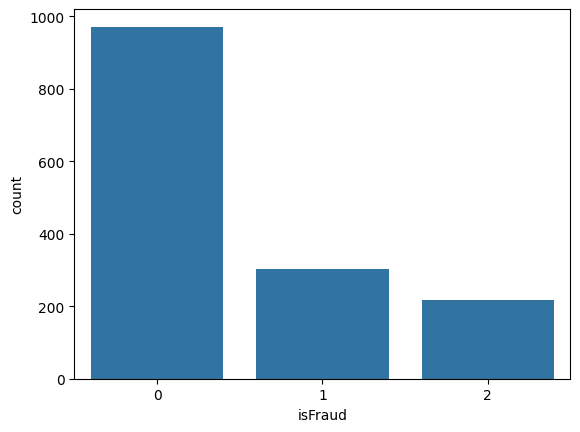

In [131]:
sns.countplot(data = test, x = 'isFraud')

### Reproducible function

In [ ]:
def repad_kmeans(df, value_col):
    
    sequences = []
    card_ids = []
    #Repadding
    for card_id, group in df.groupby('CardID'):
        seq = group.sort_values('TransactionDT')[value_col].values
        if (len(seq) < 30) | (len(seq) > 200):
            continue
        card_ids.append(card_id)
        sequences.append(seq)

    ts_dataset = to_time_series_dataset(sequences)
    ts_dataset = TimeSeriesResampler(sz=50).fit_transform(ts_dataset) 
    
    # DTW-based clustering
    dtw_kmeans = TimeSeriesKMeans(n_clusters=4, metric="softdtw", random_state=42)
    cluster_labels = dtw_kmeans.fit_predict(ts_dataset)

    dtw_clusters_df = pd.DataFrame({'CardID': card_ids, 'dtw_cluster': cluster_labels})
    
    #Plot the Centroids for each cluster
    centroids = dtw_kmeans.cluster_centers_
    labels = cluster_labels
    X = ts_dataset

    # Ensure X is 2D: (n_samples, time_length)
    if X.ndim == 3:
        X = X.squeeze(-1)

    n_clusters = len(centroids)
    n_rows, n_cols = 2, 2

    colors = ['blue', 'green', 'red', 'orange']

    # Find global y-limits to set scale for all graphs
    all_values = np.concatenate([c.squeeze() for c in centroids])
    y_min, y_max = all_values.min(), all_values.max()

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 6))
    axes = axes.flatten()

    for i, centroid in enumerate(centroids):
        ax = axes[i]
        cluster_ts = X[labels == i] 
        n_series = cluster_ts.shape[0]
        mean_ts = np.mean(cluster_ts, axis=0)
        std_ts = np.std(cluster_ts, axis=0)
        ci_margin = 1.96 * std_ts / np.sqrt(n_series)  # 95% CI (5% alpha)

        color = colors[i % len(colors)]
        ax.plot(centroid.squeeze(), color=color, label='Centroid')
        ax.fill_between(range(len(mean_ts)),
                        mean_ts - ci_margin,
                        mean_ts + ci_margin,
                        color=color,
                        alpha=0.2,
                        label='95% CI')
        ax.set_title(f"Cluster {i}")
        ax.set_ylim(y_min, y_max)
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.grid(True)
        ax.legend()

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.tight_layout()
    plt.show()
    
    #Crosstab for comparison
    cardid_counts = df['CardID'].value_counts()
    cardids_over = cardid_counts[(cardid_counts >= 30) & (cardid_counts <= 200)].index

    filtered_df = df[df['CardID'].isin(cardids_over)]

    test = filtered_df.groupby('CardID')['isFraud'].max().reset_index()
    
    high_fraud_cards = card_summary[card_summary['Fraud_level'] == 2]['CardID'].unique()

    high_fraud_card_list = high_fraud_cards.tolist()

    test.loc[test['CardID'].isin(high_fraud_card_list), 'isFraud'] = 2
    
    checking_dtw = pd.merge(test, dtw_clusters_df, on = 'CardID', how = 'left')

    print(pd.crosstab(checking_dtw['dtw_cluster'], checking_dtw['isFraud']))

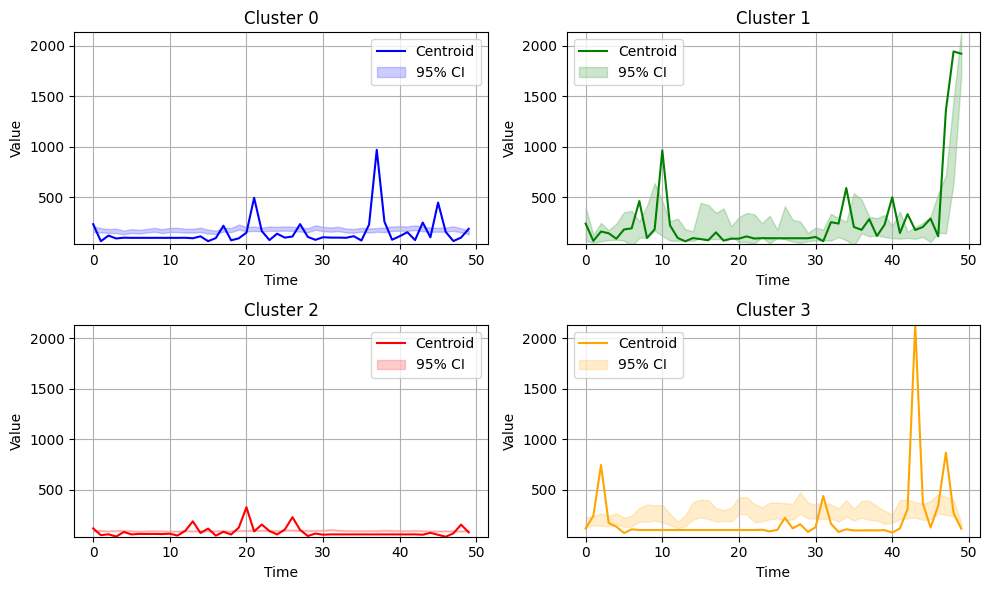

isFraud        0    1    2
dtw_cluster               
0            234  108   60
1             14    2    1
2            658  152  137
3             65   40   20


In [23]:
repad_kmeans(df, 'TransactionAmt')

### By Engineering Encoded Factors

In [31]:
df.columns

Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'CardID',
       'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
       'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'DeviceType', 'VerificationSet', 'MatchingCount', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'],
      dtype='object')

In [24]:
X = df[['CardID', 'TransactionDT', 'isFraud']]

scaledown_factor = df[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']]

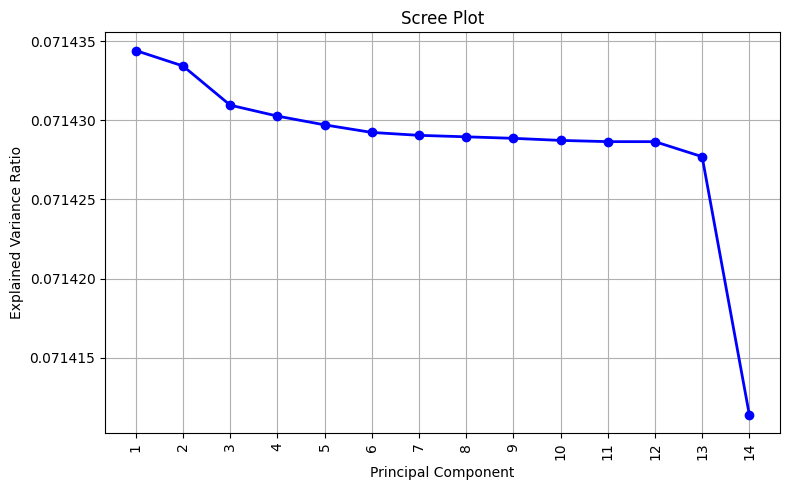

In [27]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(scaledown_factor)

# Apply PCA
pca = PCA()
pca.fit(scaled_data)

# Explained variance
explained_variance = pca.explained_variance_ratio_
components = np.arange(1, len(explained_variance) + 1)

# Plot Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(components, explained_variance, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(components, rotation = 90)
plt.grid(True)
plt.tight_layout()
plt.show()

#### 2 Approaches to extract 1 Column from these

Approach 1: Autoencoder to maintain information

In [25]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(scaledown_factor)

# ---- STEP 2: Build Autoencoder ----

input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)
bottleneck = Dense(1, activation='linear', name='bottleneck')(encoded)

# Decoder
decoded = Dense(16, activation='relu')(bottleneck)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

# Build model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

# ---- STEP 3: Train Autoencoder ----

autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=64, validation_split=0.1, verbose=1)

# ---- STEP 4: Extract 1D encoded feature ----

encoder = Model(inputs=input_layer, outputs=autoencoder.get_layer("bottleneck").output)
compressed_1d = encoder.predict(X_scaled).squeeze()

# ---- STEP 5: Add to original DataFrame ----

X['Autoencode'] = compressed_1d

Epoch 1/50
8261/8261 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 8.7613e-04 - val_loss: 7.0422e-04
Epoch 2/50
8261/8261 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 5.2850e-05 - val_loss: 7.5275e-04
Epoch 3/50
8261/8261 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 4.6910e-05 - val_loss: 7.3304e-04
Epoch 4/50
8261/8261 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 4.3985e-05 - val_loss: 7.4390e-04
Epoch 5/50
8261/8261 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 4.3935e-05 - val_loss: 7.4301e-04
Epoch 6/50
8261/8261 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 4.3501e-05 - val_loss: 7.2122e-04
Epoch 7/50
8261/8261 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 4.0385e-05 - val_loss: 7.2046e-04
Epoch 8/50
8261/8261 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 4.1047e-05 - val_loss: 7.1400e-04
Epoch 9/50
8261/8261 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 4.0392e-05 - val_loss: 7.0650e-04
Epoch 10/50
8261/8261 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 3.9890e-05 - val_loss: 7.0130e-04
Epoch 11/50
8261/8261 ━━━━━━━

C:\Users\admin\AppData\Local\Temp\ipykernel_2328\1234331369.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Autoencode'] = compressed_1d


Approach 2: Weighted-Sum based on Explained Importance

In [28]:
evr = pca.explained_variance_ratio_

# Weighted sum
weighted_sum = np.dot(scaledown_factor, evr)

# Add to the DataFrame
X["Weighted_Sum"] = weighted_sum

C:\Users\admin\AppData\Local\Temp\ipykernel_2328\1115184072.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Weighted_Sum"] = weighted_sum


In [34]:
X

CardID  TransactionDT  isFraud  Autoencode  Weighted_Sum
0        13926      24.000000        0   -0.247285     -0.333581
1         2755      24.000278        0   -0.267936     -0.450093
2         4663      24.019167        0   -0.249932     -0.292224
3        18132      24.027500        0   -0.259542     -0.085571
4         4497      24.029444        0   -0.260282     -0.233085
...        ...            ...      ...         ...           ...
587436    6550    4391.957500        0   -0.200519     -0.140181
587437   10444    4391.958056        0   -0.249932     -0.292224
587438   12037    4391.966389        0   -0.197972      0.014677
587439    7826    4391.968889        0   -0.280356      0.572663
587440   15066    4391.980833        0   -0.192562      0.676035

[587439 rows x 5 columns]

<Axes: xlabel='Weighted_Sum', ylabel='Autoencode'>

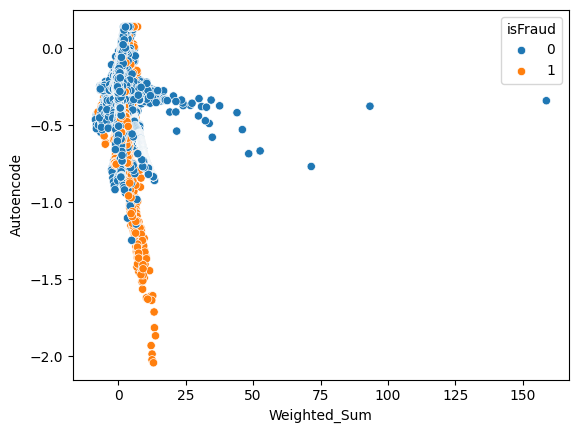

In [30]:
sns.scatterplot(data = X, x = 'Weighted_Sum', y = 'Autoencode', hue = 'isFraud')

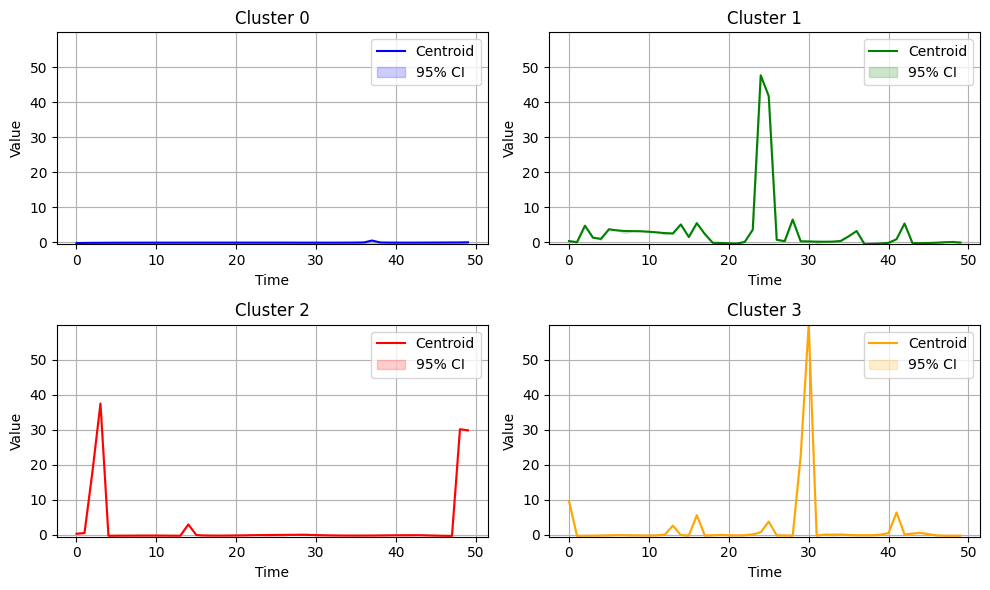

isFraud        0    1    2
dtw_cluster               
0            971  300  217
1              0    1    0
2              0    1    0
3              0    0    1


In [36]:
repad_kmeans(X, 'Weighted_Sum')

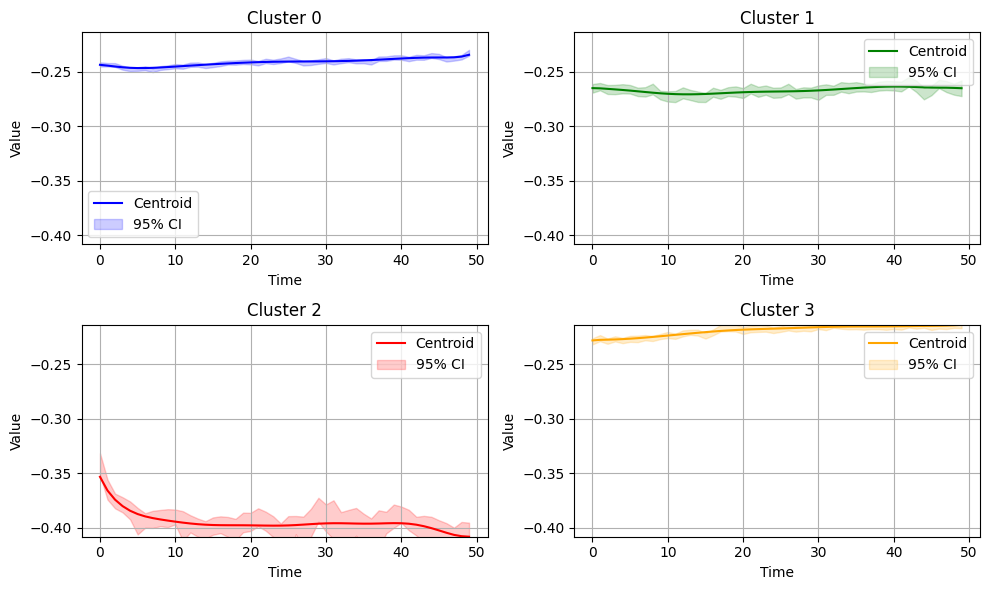

isFraud        0    1   2
dtw_cluster              
0            477  160  84
1            109   49  38
2             31   21  72
3            354   72  24


In [37]:
repad_kmeans(X, 'Autoencode')

## Feature Based Analysis

#### Extract function to get relative features:
* Number of transactions
* Mean transaction
* Std, max, min transaction
* Skewness, kurtosis 
* Mean Time between transactions
* Std of time between transactions

A small note here is that Constant distribution of data or too few data points in the time series will make the Skewness/ Kurtosis Null, so we have to add some other conditions to make use of all relevant data

In [ ]:
def extract_features(df):
    features = []

    for card_id, group in df.groupby('CardID'):
        if len(group) <= 1:
            continue  # Skip CardIDs with 1 or 0 transactions

        times = group['TransactionDT'].values
        amounts = group['TransactionAmt'].values
        deltas = np.diff(times)

        skew = pd.Series(amounts).skew()
        kurt = pd.Series(amounts).kurt()

        feature = {
            'CardID': card_id,
            'transactions': len(amounts),
            'mean_amount': np.mean(amounts),
            'std_amount': np.std(amounts),
            'max_amount': np.max(amounts),
            'min_amount': np.min(amounts),
            'amount_skew': 0 if pd.isna(skew) else skew,
            'amount_kurt': 0 if pd.isna(kurt) else kurt,
            'mean_time_delta': np.mean(deltas),
            'std_time_delta': np.std(deltas),
        }

        features.append(feature)

    return pd.DataFrame(features)

In [70]:
fraud = df1[df1['isFraud'] == 1].index
non_fraud = df1[df1['isFraud'] == 0].index

fraud = df[df['CardID'].isin(fraud)]
non_fraud = df[df['CardID'].isin(non_fraud)]

fraud_df = extract_features(fraud)
non_fraud_df = extract_features(non_fraud)

fraud_df['fraud'] = 1
non_fraud_df['fraud'] = 0

feature = pd.concat([fraud_df, non_fraud_df], axis = 0)

feature = feature.drop('CardID', axis = 1)

In [71]:
feature

transactions  mean_amount  std_amount  max_amount  min_amount  \
0                8   279.607500  234.906457     749.610      50.000   
1                8    92.687125  138.050385     450.000      19.999   
2              530    95.657736  124.451488    1104.000       5.000   
3                3   107.950000    0.000000     107.950     107.950   
4               13    79.769231   62.084501     200.000      25.000   
...            ...          ...         ...         ...         ...   
6329             6    80.308333   34.055193     117.000      39.000   
6330             2    59.000000    0.000000      59.000      59.000   
6331             6    62.733333   56.787804     169.950      24.500   
6332            41   284.373171  547.589469    2546.950      57.950   
6333             2    41.622000   19.735000      61.357      21.887   

      amount_skew  amount_kurt  mean_time_delta  std_time_delta  fraud  
0        1.050657     0.025271       539.365516      530.097915      1  
1        2.604877     6.963466       409.701944      417.126583      1  
2        4.136756    21.977842         8.226745       10.119129      1  
3        0.000000     0.000000      1223.176667      192.994722      1  
4        0.965490    -0.184769       341.546227      172.561943      1  
...           ...          ...              ...             ...    ...  
6329    -0.028496    -3.077887       773.721389      427.005007      0  
6330     0.000000     0.000000         0.845278        0.000000      0  
6331     1.375240     0.516608       695.555389     1238.036273      0  
6332     3.622258    12.981991       104.588236      106.505564      0  
6333     0.000000     0.000000       139.646944        0.000000      0  

[7267 rows x 10 columns]

In [72]:
feature['fraud'].value_counts()

fraud
0    6334
1     933
Name: count, dtype: int64

### Now just fit and train as normal Classification 

In [74]:
X = feature.drop('fraud', axis = 1)
y = feature[['fraud']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [78]:
models = {
                "Logistic Regressor": LogisticRegression(),
                "Decision Tree": DecisionTreeClassifier(),
                "Random Forest Classifier": RandomForestClassifier(),
                "XGBClassifier": XGBClassifier(), 
                "AdaBoost Classifier": AdaBoostClassifier(),
                'CatBoosting Classifier': CatBoostClassifier(),
                'Gradient Boosting': GradientBoostingClassifier()
            }
            
params={
    "Decision Tree": {
        'criterion':['gini', 'entropy', 'log_loss'],
        # 'splitter':['best','random'],
        # 'max_features':['sqrt','log2'],
    },
    "Random Forest Classifier":{
         'criterion':['gini', 'entropy', 'log_loss'],
        
        # 'max_features':['sqrt','log2',None],
        'n_estimators': [8,16,32,64,128,256]
    },
    "Gradient Boosting":{
        'loss':['log_loss', 'exponential'],
        'learning_rate':[.1,.01,.05,.001],
        'subsample':[0.6,0.7,0.75,0.8,0.85,0.9],
        'criterion':['squared_error', 'friedman_mse'],
        # 'max_features':['auto','sqrt','log2'],
        'n_estimators': [8,16,32,64,128,256]
    },
    "Logistic Regressor":{},
    "XGBClassifier":{
        'learning_rate':[.1,.01,.05,.001],
        'n_estimators': [16,32,64,128,256]
    },
    "CatBoosting Classifier":{
        'depth': [6,8,10],
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [30, 50, 100]
    },
    "AdaBoost Classifier":{
        'learning_rate':[.1,.01,0.5,.001],
        # 'loss':['linear','square','exponential'],
        'n_estimators': [16,32,64,128,256]
    }
}

model_best_params = {}

for model_name, param in params.items():
                model = GridSearchCV(models[model_name], param, n_jobs=-1, verbose = False)
                model.fit(X_train, y_train)
                model_best_params[model_name] = model.best_params_
                
for key, value in model_best_params.items():
    print(f'{key}: {value}')

d:\Study\Setup\anaconda\config\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Study\Setup\anaconda\config\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Study\Setup\anaconda\config\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0:	learn: 0.6877511	total: 3.4ms	remaining: 98.6ms
1:	learn: 0.6824910	total: 7.14ms	remaining: 100ms
2:	learn: 0.6772613	total: 10.3ms	remaining: 92.5ms
3:	learn: 0.6721705	total: 14.6ms	remaining: 95.2ms
4:	learn: 0.6671400	total: 18.3ms	remaining: 91.7ms
5:	learn: 0.6622524	total: 21.5ms	remaining: 86.1ms
6:	learn: 0.6574880	total: 25.3ms	remaining: 83.1ms
7:	learn: 0.6528247	total: 28.9ms	remaining: 79.5ms
8:	learn: 0.6481731	total: 32ms	remaining: 74.7ms
9:	learn: 0.6436745	total: 35ms	remaining: 70.1ms
10:	learn: 0.6392246	total: 38ms	remaining: 65.6ms
11:	learn: 0.6348422	total: 41.4ms	remaining: 62.1ms
12:	learn: 0.6305428	total: 44.5ms	remaining: 58.3ms
13:	learn: 0.6263083	total: 47.4ms	remaining: 54.2ms
14:	learn: 0.6221733	total: 50.1ms	remaining: 50.1ms
15:	learn: 0.6181176	total: 53.3ms	remaining: 46.7ms
16:	learn: 0.6141749	total: 57.6ms	remaining: 44.1ms
17:	learn: 0.6102870	total: 60.7ms	remaining: 40.5ms
18:	learn: 0.6064830	total: 63.7ms	remaining: 36.9ms
19:	learn: 

d:\Study\Setup\anaconda\config\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Decision Tree: {'criterion': 'entropy'}
Random Forest Classifier: {'criterion': 'entropy', 'n_estimators': 64}
Gradient Boosting: {'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'log_loss', 'n_estimators': 16, 'subsample': 0.85}
Logistic Regressor: {}
XGBClassifier: {'learning_rate': 0.1, 'n_estimators': 16}
CatBoosting Classifier: {'depth': 6, 'iterations': 30, 'learning_rate': 0.01}
AdaBoost Classifier: {'learning_rate': 0.5, 'n_estimators': 16}


In [80]:
models = {
        "Logistic Regressor": LogisticRegression(),
        "Decision Tree": DecisionTreeClassifier(criterion='entropy'),
        "Random Forest Classifier": RandomForestClassifier(criterion='entropy', n_estimators=128),
        "XGBClassifier": XGBClassifier(learning_rate = 0.1, n_estimator = 32), 
        "AdaBoost Classifier": AdaBoostClassifier(learning_rate=0.5, n_estimators=64),
        'CatBoosting Classifier': CatBoostClassifier(depth=6, iterations = 30, learning_rate = 0.01),
        'Gradient Boosting': GradientBoostingClassifier(criterion='squared_error', learning_rate=0.1, loss='log_loss', n_estimators=64, subsample=0.85)
}

model_result = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    model_result[model_name] = accuracy
    model_resut = dict(sorted(model_result.items(), key=lambda item: item[1], reverse=True))

for model_name, accuracy in model_resut.items():
    print(f"{model_name}: {accuracy:.4f}")

d:\Study\Setup\anaconda\config\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Study\Setup\anaconda\config\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\Study\Setup\anaconda\config\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:53:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\Study\Setup\anaconda\config\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

0:	learn: 0.6877511	total: 3.35ms	remaining: 97ms
1:	learn: 0.6824910	total: 7.16ms	remaining: 100ms
2:	learn: 0.6772613	total: 9.85ms	remaining: 88.7ms
3:	learn: 0.6721705	total: 12.3ms	remaining: 80.1ms
4:	learn: 0.6671400	total: 14.9ms	remaining: 74.6ms
5:	learn: 0.6622524	total: 17.9ms	remaining: 71.5ms
6:	learn: 0.6574880	total: 21.1ms	remaining: 69.3ms
7:	learn: 0.6528247	total: 24.3ms	remaining: 66.9ms
8:	learn: 0.6481731	total: 27.1ms	remaining: 63.3ms
9:	learn: 0.6436745	total: 29.8ms	remaining: 59.6ms
10:	learn: 0.6392246	total: 32.7ms	remaining: 56.4ms
11:	learn: 0.6348422	total: 35.3ms	remaining: 52.9ms
12:	learn: 0.6305428	total: 38.2ms	remaining: 49.9ms
13:	learn: 0.6263083	total: 41.1ms	remaining: 46.9ms
14:	learn: 0.6221733	total: 44.1ms	remaining: 44.1ms
15:	learn: 0.6181176	total: 47.7ms	remaining: 41.8ms
16:	learn: 0.6141749	total: 50.6ms	remaining: 38.7ms
17:	learn: 0.6102870	total: 53.6ms	remaining: 35.7ms
18:	learn: 0.6064830	total: 56.4ms	remaining: 32.7ms
19:	le

d:\Study\Setup\anaconda\config\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regressor: 0.8666
XGBClassifier: 0.8666
CatBoosting Classifier: 0.8666
Gradient Boosting: 0.8666
AdaBoost Classifier: 0.8659
Random Forest Classifier: 0.8624
Decision Tree: 0.7724


#### The Accuracy is high so we can use this to fit the Predictor

In [86]:
import pickle

model = models['Gradient Boosting']

with open('D:/Study/Education/Projects/ML2/Final/artifacts/time_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [134]:
card = df[df['CardID'] == 2801]

In [162]:
card = card[['TransactionDT', 'TransactionAmt']]
card


TransactionDT  TransactionAmt
551         26.683333          10.996
838         29.153056          51.357
849         29.349722          42.294
1064        32.258333          90.872
1069        32.304444          90.872
...               ...             ...
579398    4320.450278          43.282
580138    4333.726944          11.189
580191    4334.099722          10.021
581048    4338.823056          77.711
581801    4343.218889         107.959

[387 rows x 2 columns]

In [175]:
def extract(df):
    times = df['TransactionDT'].values
    amounts = df['TransactionAmt'].values
    deltas = np.diff(times)

    skew = pd.Series(amounts).skew()
    kurt = pd.Series(amounts).kurt()

    feature = {
        'transactions': len(amounts),
        'mean_amount': np.mean(amounts),
        'std_amount': np.std(amounts),
        'max_amount': np.max(amounts),
        'min_amount': np.min(amounts),
        'amount_skew': 0 if pd.isna(skew) else skew,
        'amount_kurt': 0 if pd.isna(kurt) else kurt,
        'mean_time_delta': np.mean(deltas),
        'std_time_delta': np.std(deltas),
    }
    
    return pd.DataFrame([feature])

In [184]:
scaler.fit(X)

StandardScaler()

In [186]:
with open('D:/Study/Education/Projects/ML2/Final/artifacts/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
with open('D:/Study/Education/Projects/ML2/Final/artifacts/scaler.pkl', 'rb') as f:
    scale = pickle.load(f)

nice = pd.DataFrame(scale.transform(extract(card)), columns = extract(card).columns)
nice


transactions  mean_amount  std_amount  max_amount  min_amount  amount_skew  \
0      0.868781    -0.582197   -0.409012   -0.278621   -0.625006      0.43156   

   amount_kurt  mean_time_delta  std_time_delta  
0      0.02514         -0.77235       -0.832196

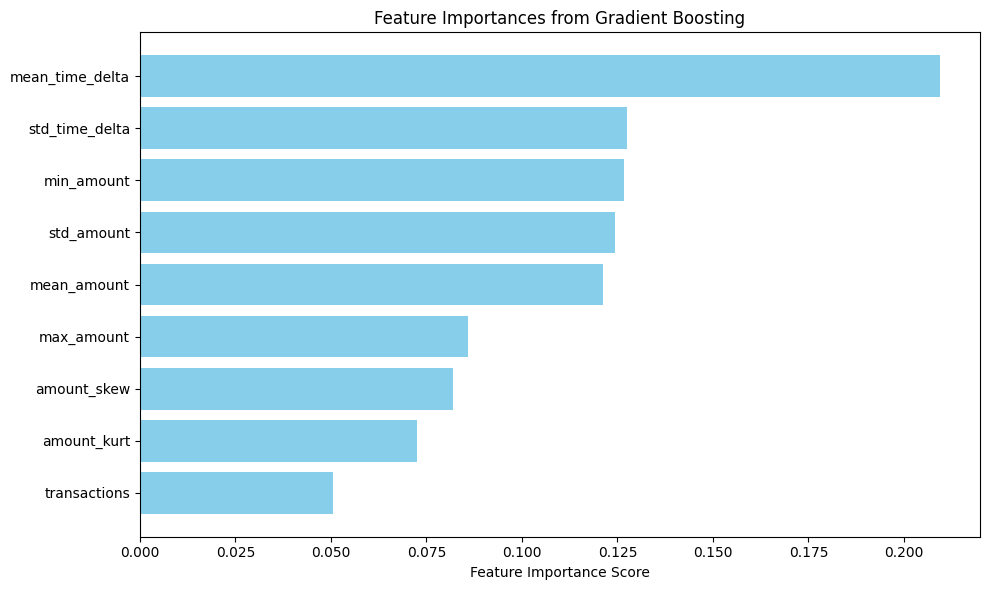

In [188]:
feature_names = [
    'transactions',
    'mean_amount',
    'std_amount',
    'max_amount',
    'min_amount',
    'amount_skew',
    'amount_kurt',
    'mean_time_delta',
    'std_time_delta'
]

# Get feature importances from model
importances = model.feature_importances_

# Combine into a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance Score')
plt.title('Feature Importances from Gradient Boosting')
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()